## 04. Github with different Tuplex modes
This notebook contains analysis of the results when running `github/run-tuplex-experiments.sh`. As sampling mode first/last file and first/last rows are used (this is different than the default tuplex sampling mode!).

In [105]:
import pandas as pd
import json
import zipfile

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

In [106]:
# load results from path for plotting
results_path = '../github/local-exp/github/combined.ndjson'
df = pd.read_json(results_path, lines=True)

In [107]:
df.head()

,run,mode,input_path,output_path,time_in_s,loading_time_in_s,total_time_in_s,input_row_count,output_row_count,benchmark,metrics,startup_time_in_s,per_file_stats,hyper,request_time_in_s,compile_time_in_s,fast_path_execution_time_in_s,general_and_interpreter_time_in_s,hyperspecialization_time
0,3,python,/hot/data/github_daily/2011-10-15.json,./local-exp/github//output/python,0.332677,NaN,135.317727,48899,1418,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,3,python,/hot/data/github_daily/2012-10-15.json,./local-exp/github//output/python,1.165685,NaN,135.317727,165692,5907,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,3,python,/hot/data/github_daily/2013-10-15.json,./local-exp/github//output/python,2.382360,NaN,135.317727,296456,10628,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
3,3,python,/hot/data/github_daily/2014-10-15.json,./local-exp/github//output/python,8.686575,NaN,135.317727,476393,16014,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4,3,python,/hot/data/github_daily/2015-10-15.json,./local-exp/github//output/python,7.443211,NaN,135.317727,737714,25301,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# Plot modes against each other (horizontal) incl. how much time is spent on hyperspecialization, client-side, request side.

In [238]:
# ignore first warm-up/verification run
df = df[df['run'] != 0]

In [239]:
part_df_A = df.groupby(['run', 'mode'])[['hyperspecialization_time', 'request_time_in_s']].sum()

In [240]:
# combine with total runtime
part_df_B = df.groupby(['run', 'mode'])[['total_time_in_s']].first()

In [241]:
df_totals = pd.concat((part_df_A, part_df_B), axis=1).reset_index()

In [242]:
df_totals = df_totals.sort_values(by='total_time_in_s').reset_index(drop=True)

In [243]:
modes = df_totals['mode'].unique()
modes

array(['tuplex-hyper-sparse-structs', 'tuplex-global-sparse-structs',
       'tuplex-hyper-generic-dicts', 'tuplex-global-generic-dicts',
       'tuplex-global-structs', 'python'], dtype=object)

Text(0.5, 1.0, 'hyper vs. global\n(same optimizations applied)')

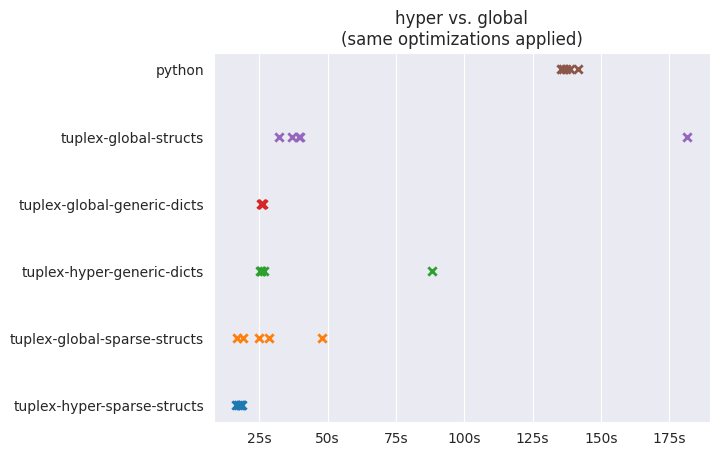

In [244]:
from matplotlib.ticker import EngFormatter

for i, mode in enumerate(modes):
    y = df_totals[df_totals['mode'] == mode]['total_time_in_s']
    x = [i] * len(y)
    plt.scatter(y, x, linewidth=2, marker='x')
ax = plt.gca()
ax.set_yticklabels(modes)
plt.yticks(range(len(modes)), rotation=0)
ax.xaxis.set_major_formatter(EngFormatter(unit='s', sep=''))
plt.grid(axis='y')
plt.title('hyper vs. global\n(same optimizations applied)')

In [245]:
# Breakdown plot, i.e. using averages + std for now

# 10th Percentile
def q10(x):
    return x.quantile(0.5)

# 90th Percentile
def q90(x):
    return x.quantile(0.9)

gdf = df_totals.groupby('mode').agg(['mean', 'std', q10, q90]).reset_index()
gdf

mode  run                      \
                                mean       std  q10  q90   
0                        python  3.0  1.581139  3.0  4.6   
1   tuplex-global-generic-dicts  3.0  1.581139  3.0  4.6   
2  tuplex-global-sparse-structs  3.0  1.581139  3.0  4.6   
3         tuplex-global-structs  3.0  1.581139  3.0  4.6   
4    tuplex-hyper-generic-dicts  3.0  1.581139  3.0  4.6   
5   tuplex-hyper-sparse-structs  3.0  1.581139  3.0  4.6   

  hyperspecialization_time                               request_time_in_s  \
                      mean       std       q10       q90              mean   
0                  0.00000  0.000000  0.000000  0.000000          0.000000   
1                  0.00000  0.000000  0.000000  0.000000         25.465658   
2                  0.00000  0.000000  0.000000  0.000000         19.699342   
3                  0.00000  0.000000  0.000000  0.000000         57.888695   
4                  0.00000  0.000000  0.000000  0.000000         37.714897   
5                  4.48186  0.810218  4.049194  5.378826         17.100139   

                                    total_time_in_s                         \
         std        q10         q90            mean        std         q10   
0   0.000000   0.000000    0.000000      137.769170   2.479254  137.029233   
1   0.285328  25.587888   25.700048       26.008024   0.288771   26.137623   
2   9.992661  15.626427   28.879662       27.401593  12.418418   24.839363   
3  68.680441  26.599642  120.286051       66.052436  64.665360   39.615109   
4  27.866314  25.115469   63.025579       38.243744  27.871835   25.635654   
5   0.763562  17.345355   17.805210       17.672531   0.841686   17.858965   

               
          q90  
0  140.452733  
1   26.243210  
2   40.187735  
3  124.975192  
4   63.563465  
5   18.478392

In [246]:
gdf[('other_time_in_s', 'mean')] = gdf[('total_time_in_s', 'mean')] - gdf[('request_time_in_s', 'mean')]
gdf[('compute_time_in_s', 'mean')] = gdf[('request_time_in_s', 'mean')] - gdf[('hyperspecialization_time', 'mean')]

In [247]:
gdf = gdf.sort_values(by=('total_time_in_s', 'mean')).reset_index(drop=True)

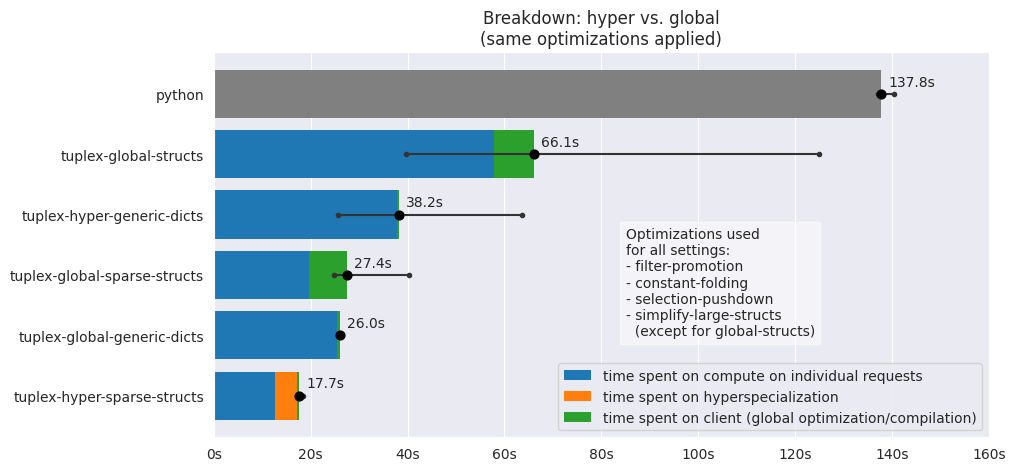

In [296]:
plt.figure(figsize=(10,5))
kwargs={'edgecolor':None, 'lw':0}

h = gdf[('compute_time_in_s', 'mean')]
plt.barh(gdf.index, h, **kwargs, label='time spent on compute on individual requests')
hh = gdf[('hyperspecialization_time', 'mean')]
plt.barh(gdf.index, hh, left=h, **kwargs, label='time spent on hyperspecialization')
hhh = gdf[('other_time_in_s', 'mean')]
handle = plt.barh(gdf.index, hhh, left=h + hh, **kwargs, label='time spent on client (global optimization/compilation)')
# modify python handle
handle[-1].set_color([.5]*3)
# plot total error bar
mu = gdf[('total_time_in_s', 'mean')]
sigma = gdf[('total_time_in_s', 'std')]
q10 = gdf[('total_time_in_s', 'q10')]
q90 = gdf[('total_time_in_s', 'q90')]

for lower,upper,y in zip(q10,q90,range(len(q10))):
    plt.plot((lower,upper),(y,y),'ro-',color=[0.2]*3, markersize=3)

plt.scatter(mu, gdf.index, 40, marker='o', color='k',zorder=10)

# print runtime numbers in s
for xi, yi in zip(mu, range(len(mu))):
    plt.text(xi + 1.5, yi + .2, f'{xi:.1f}s', horizontalalignment='left', verticalalignment='center')

modes = list(gdf['mode'])
ax = plt.gca()
ax.set_yticklabels(modes)
plt.yticks(range(len(modes)), rotation=0)
ax.xaxis.set_major_formatter(EngFormatter(unit='s', sep=''))

plt.text(85, 1, 'Optimizations used\nfor all settings:\n- filter-promotion\n- constant-folding\n- selection-pushdown\n- simplify-large-structs\n  (except for global-structs)', fontsize = 10, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

plt.grid(axis='y')
plt.title('Breakdown: hyper vs. global\n(same optimizations applied)')
plt.xlim(0, 160)
plt.legend(loc='best')

In [249]:
q10

0    -0.186434
1    -0.129599
2     2.562230
3    12.608090
4    26.437327
5     0.739937
Name: (total_time_in_s, mean), dtype: float64

In [174]:
modes

[0, 1, 2, 3, 4, 5]

In [61]:
df['hyperspecialization_time'].dropna().max()

0.73634

In [57]:
df.groupby('mode')['total_time_in_s'].mean()

mode
python                          137.681719
tuplex-global-generic-dicts      36.348259
tuplex-global-sparse-structs     27.047209
tuplex-global-structs            91.542349
tuplex-hyper-generic-dicts       36.175344
tuplex-hyper-sparse-structs      17.937899
Name: total_time_in_s, dtype: float64

In [41]:
!ls ../github/local-exp/github/results/tuplex-hyper-sparse-structs/

log-run-0.ndjson  log-run-1.txt     log-run-3.ndjson  log-run-4.txt
log-run-0.txt	  log-run-2.ndjson  log-run-3.txt     log-run-5.ndjson
log-run-1.ndjson  log-run-2.txt     log-run-4.ndjson  log-run-5.txt


In [34]:
#df[df['run'] != 0].groupby('input_path')['total_time_in_s'].mean()

In [2]:
#experimental_zip_path = '../results-Jul-16th.zip'

In [3]:
def load_cc_baselines(zf):
    df_cc = pd.DataFrame()
    # the C++ baseline are directly stored as csv
    for path in filter(lambda name: name.endswith('.csv'), zf.namelist()):
    
        if path.startswith('tuplex'):
            continue
        print(f'loading {path}')
        df_cc = pd.concat((df_cc, pd.read_csv(zf.open(path))))
    df_cc = df_cc[df_cc['mode'] != 'mode']
    for name in ['time_in_s', 'loading_time_in_s', 'total_time_in_s']:
        df_cc[name] = df_cc[name].astype(float)
    for name in ['input_row_count', 'output_row_count']:
        df_cc[name] = df_cc[name].astype(int)
    return df_cc

def load_tuplex_cc(zf, path='tuplex_best_results.csv', mode=None):
    df = pd.read_csv(zf.open(path))
    
    df = df.reset_index()[['index', 'mode', 'output_path', 'total_time_in_s', 'input_row_count', 'output_row_count']].rename(columns={'index':'mode', 'mode':'input_path', 'output_path':'time_in_s'})
    df['input_path'] = df['input_path'].apply(lambda x: x[:x.rfind(':')])
    df = df[df['mode'] != 'mode']
    df['loading_time_in_s'] = 0
    for name in ['time_in_s', 'loading_time_in_s', 'total_time_in_s']:
        df[name] = df[name].astype(float)
    for name in ['input_row_count', 'output_row_count']:
        df[name] = df[name].astype(int)
    if mode is not None:
        df['mode']=mode
    return df

def preprocess_python_df(df_tplx):
    df = df_tplx.copy()
    #df = df.dropna()
    df.drop(columns='input_path', inplace=True)
    columns_to_keep = ['run', 'benchmark', 'input_path',
                           'total_time_in_s', 'mode', 'output_path', 'startup_time_in_s']
    df = df.explode('per_file_stats')
    df.reset_index(drop=True, inplace=True)
    
    def expand_helper(t):
        if pd.isna(t) or t is None:
            return pd.Series()
        data = {'input_row_count': t['num_input_rows'],
                'output_row_count': t['num_output_rows'],
                'time_in_s': t['duration'],
                'input_path': t['input_path']
               }
        
        return pd.Series(list(data.values()), index=(data.keys()))
    df = pd.merge(df, df['per_file_stats'].apply(expand_helper), left_index=True, right_index=True)
    
    df['mode'] = 'python'
    df['loading_time_in_s'] = np.nan
    df['total_time_in_s'] = df['job_time_in_s']
    cols = ['mode', 'input_path', 'output_path', 'time_in_s', 'loading_time_in_s',
       'total_time_in_s', 'input_row_count', 'output_row_count']
    return df[cols]

def load_python(zf):
    df = pd.read_json(zf.open('python_baseline.ndjson'), lines=True)
    return preprocess_python_df(df)

with zipfile.ZipFile(experimental_zip_path, 'r') as zf:
    print(zf.namelist())
    
    df_cc = load_cc_baselines(zf)
    
    df_tuplex_cc = pd.DataFrame()
    for path in ['tuplex_best_results.csv', 'tuplex_cjson_results.csv', 'tuplex_yyjson_results.csv']:  
        df_tuplex_cc = pd.concat((load_tuplex_cc(zf, path), df_tuplex_cc))
    
    df_python = load_python(zf)
    
    

['best_results.csv', 'cjson_results.csv', 'cstruct_results.csv', 'python_baseline.ndjson', 'tuplex_best_results.csv', 'tuplex_cjson_results.csv', 'tuplex_yyjson_results.csv', 'yyjson_results.csv']
loading best_results.csv
loading cjson_results.csv
loading cstruct_results.csv
loading yyjson_results.csv


In [4]:
df_cc['mode'].unique(), df_tuplex_cc['mode'].unique(), df_python['mode'].unique()

(array(['best', 'cjson', 'cstruct', 'yyjson'], dtype=object),
 array(['tuplex-c++-yyjson', 'tuplex-c++-cjson', 'tuplex-c++-sparse'],
       dtype=object),
 array(['python'], dtype=object))

In [5]:
df = pd.concat((df_cc, df_python, df_tuplex_cc))

In [6]:
def plot_total_time(df, normalize_to_best=False):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    
    if normalize_to_best:
        best_mean = df[df['mode'] == 'best']['total_time_in_s'].mean()
        df['total_time_in_s'] = df['total_time_in_s'] / best_mean
    
    sns.barplot(data=df.sort_values(by='total_time_in_s'), x='mode', y='total_time_in_s', capsize=.2)
    plt.xticks(rotation=90)
    
    if not normalize_to_best:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
        plt.ylabel('total time')
    else:
        plt.axhline(1, lw=2, linestyle='--', color='k')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}x'))
        plt.ylabel('total time relative to best C++ baseline')

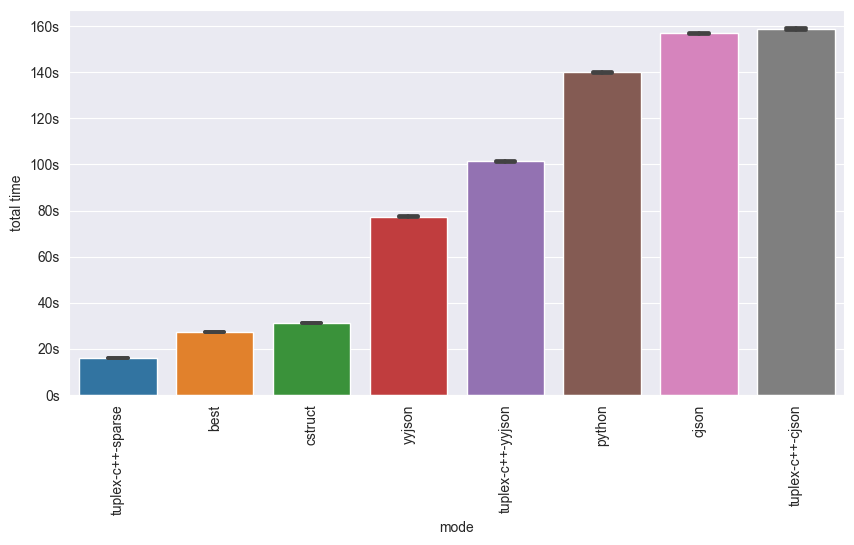

In [7]:
plot_total_time(df)

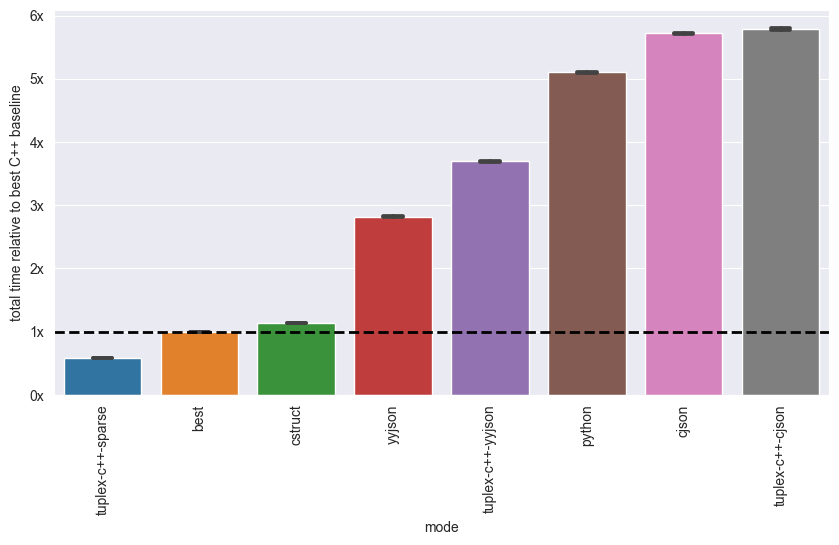

In [8]:
plot_total_time(df, True)

In [9]:
df[df['mode'] == 'tuplex-c++-sparse']['total_time_in_s'].mean()

16.151292333333338

In [10]:
df[df['mode'] == 'python']['total_time_in_s'].mean()

139.93298208713531

In [11]:
def plot_per_file_runtimes(df, modes=['best', 'python'], normalize_to=None):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    
    df = df[df['mode'].isin(modes)]
    import os
    df['input_path'] = df['input_path'].apply(os.path.basename)
    
    normalized_best_label = f'time_factor_compared_to_{normalize_to}'
    
    if normalize_to is not None:
        def helper(g):
            g[normalized_best_label] = g['time_in_s'] / g[g['mode'] == normalize_to]['time_in_s'].mean()
            return g
        df = df.groupby(['input_path'], group_keys=False).apply(helper)
    
    sns.barplot(df.sort_values(by=['time_in_s']), x='input_path',
                y=normalized_best_label if normalize_to is not None else 'time_in_s',
                hue='mode', errorbar=None, capsize=0)
    plt.xticks(rotation=90)
    
    if normalize_to is None:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
        plt.ylabel('time per file')
    else:
        plt.axhline(1, lw=2, linestyle='--', color='k')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}x'))
        plt.ylabel('total time relative to best C++ baseline')

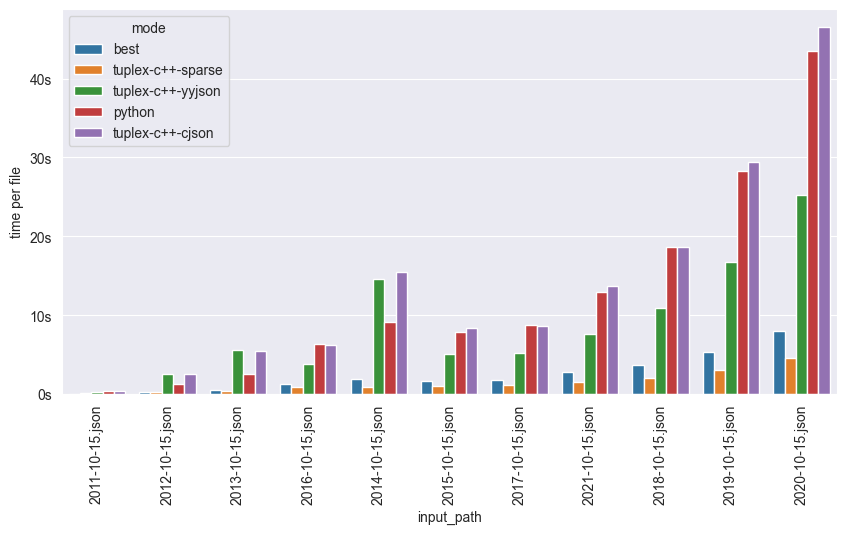

In [12]:
select_modes = ['best', 'tuplex-c++-sparse', 'tuplex-c++-yyjson', 'tuplex-c++-cjson', 'python']
plot_per_file_runtimes(df, modes=select_modes)

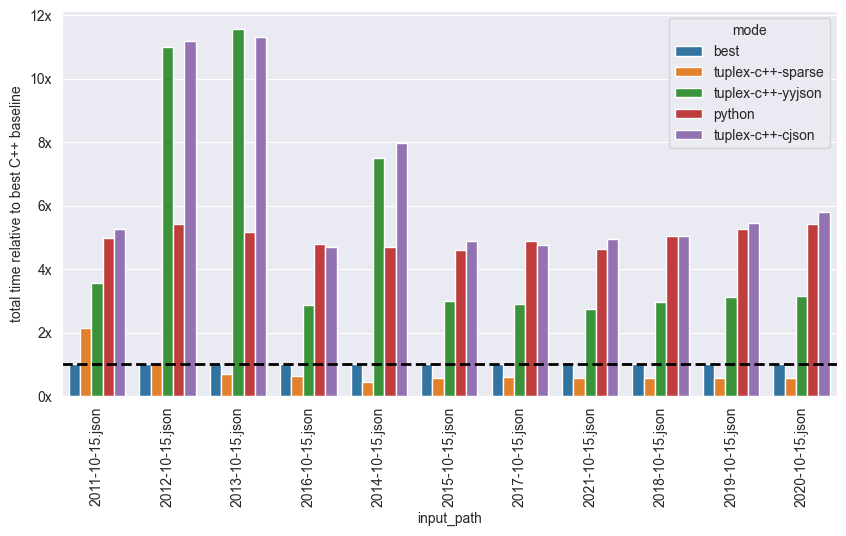

In [13]:
plot_per_file_runtimes(df, modes=select_modes, normalize_to='best')